<a href="https://colab.research.google.com/github/RahulPil/Classifying-Handwritten-Digits/blob/main/Classifying%20Handwritten%20Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.io import loadmat
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# load the dataset
data = loadmat('USPS_all.mat')
X = data['fea']
y = data['gnd']
y = [int(i-1) for i in y]
y = to_categorical(y, num_classes=10)

# get testing and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)
# one hot encode the target datasets as the last layer of the model is a dense layer with the softmax function

# function to wrap network so that we can use grid search to fine tune the hyperparameters of the model
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the Keras classifier
model = KerasClassifier(model=create_model, verbose=2)

# Define the grid search parameters
optimizers = ['adam', 'sgd']
activations = ['relu', 'sigmoid']
epochs = [5, 10]
batches = [32, 64]

# variables that will be fine tuned using grid search
param_grid = dict(model__optimizer=optimizers, model__activation=activations, epochs=epochs, batch_size=batches)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,
                    scoring='f1_micro', verbose=2)

# use grid search to find the best combination of hyperparameters
grid_result = grid.fit(X_train, y_train)

# found the best network
print('Best parameters for model: ', grid_result.best_params_)
print('Best accuracy: ', grid_result.best_score_)

(7438, 10)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/5
155/155 - 1s - loss: 0.8259 - accuracy: 0.7656 - 1s/epoch - 9ms/step
Epoch 2/5
155/155 - 0s - loss: 0.2639 - accuracy: 0.9250 - 334ms/epoch - 2ms/step
Epoch 3/5
155/155 - 0s - loss: 0.1954 - accuracy: 0.9486 - 331ms/epoch - 2ms/step
Epoch 4/5
155/155 - 0s - loss: 0.1676 - accuracy: 0.9526 - 336ms/epoch - 2ms/step
Epoch 5/5
155/155 - 0s - loss: 0.1439 - accuracy: 0.9611 - 339ms/epoch - 2ms/step
78/78 - 0s - 132ms/epoch - 2ms/step
[CV] END batch_size=32, epochs=5, model__activation=relu, model__optimizer=adam; total time=   3.1s
Epoch 1/5
155/155 - 1s - loss: 0.7963 - accuracy: 0.7659 - 1s/epoch - 9ms/step
Epoch 2/5
155/155 - 0s - loss: 0.2591 - accuracy: 0.9264 - 333ms/epoch - 2ms/step
Epoch 3/5
155/155 - 0s - loss: 0.2041 - accuracy: 0.9387 - 330ms/epoch - 2ms/step
Epoch 4/5
155/155 - 0s - loss: 0.1720 - accuracy: 0.9504 - 328ms/epoch - 2ms/step
Epoch 5/5
155/155 - 0s - loss: 0.1465 - accuracy: 0.9548 - 3

In [ ]:
# find the performance metrics and display them
y_ordinal_test = np.argmax(y_test, axis=1)
y_pred = grid_result.best_estimator_.predict(X_test)
y_ordinal_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_ordinal_test, y_ordinal_pred)
print(cm)
print('AUC Score: ', roc_auc_score(y_test, y_pred, multi_class='ovr'))


59/59 - 0s - 86ms/epoch - 1ms/step
[[333   0   1   1   1   0   1   0   0   0]
 [  0 239   1   0   2   0   0   0   1   0]
 [  1   0 159   1   2   1   0   0   2   0]
 [  0   0   2 171   0   1   0   0   2   0]
 [  0   1   1   0 158   0   0   1   0   3]
 [  1   0   3   4   2 144   5   0   0   0]
 [  0   0   3   0   1   0 155   0   1   0]
 [  0   0   1   0   1   0   0 153   1   1]
 [  1   1   2   7   0   1   2   0 123   2]
 [  0   0   1   0   4   0   0   4   0 150]]
AUC Score:  0.9748640489372843


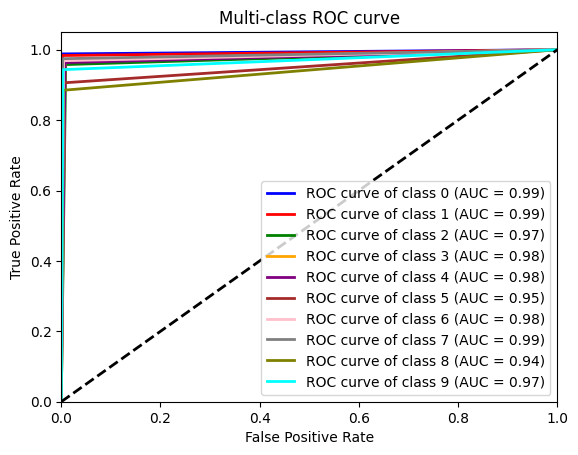

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import f1_score
# Compute macro-averaged F1-score
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Macro-averaged F1-score: {:.3f}".format(f1_macro))

Macro-averaged F1-score: 0.955
